In [ ]:
from julia.api import Julia
jl = Julia(compiled_modules = False)

In [1]:
import os
os.environ["CDF_LIB"] = "~/CDF/lib"
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import julian
import nrlmsise00

from numpy import floor
from spacepy import pycdf
from tqdm import tqdm
%matplotlib widget

In [2]:
sat = 'GRACEA'
sat_in_filename = 'graceA'
start = dt.datetime(2005,8,1,0,0,0)
stop = dt.datetime(2005,9,1,0,0,0)
year = 2005
no_of_days = int(np.ceil((stop - start)/dt.timedelta(days=1)))


In [3]:
%load_ext julia.magic
%julia using Dates;
%julia using LinearAlgebra;
%julia using DataFrames;
%julia using SatelliteToolbox;
%julia init_space_indices();
#dtcfile_force_download = true,fluxtable_force_download = true,solfsmy_force_download=true,wdcfiles_force_download = true,wdcfiles_oldest_year = 2000,wdcfiles_newest_year = 2010

Initializing Julia interpreter. This may take some time...


[ Info: Downloading file 'DTCFILE.TXT' from 'http://sol.spacenvironment.net/jb2008/indices/DTCFILE.TXT' with cURL.
[ Info: Downloading file 'fluxtable.txt' from 'ftp://ftp.seismo.nrcan.gc.ca/spaceweather/solar_flux/daily_flux_values/fluxtable.txt' with cURL.
[ Info: Downloading file 'SOLFSMY.TXT' from 'http://sol.spacenvironment.net/jb2008/indices/SOLFSMY.TXT' with cURL.
[ Info: Downloading file 'kp2023.wdc' from 'ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/wdc/yearly/kp2023.wdc' with cURL.


In [7]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = sat + '_Mehta_' + start.strftime("%Y-%m-%d") +'.csv';
GRACE_Data = pd.read_csv(filename)
GRACE_Data.index = pd.DatetimeIndex(GRACE_Data['Unnamed: 0'])
GRACE_Data = GRACE_Data.drop('Unnamed: 0',axis=1)
df1 = GRACE_Data
# df1 = GRACE_Data.iloc[np.arange(0,len(GRACE_Data),12),:];

In [9]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/'
os.chdir(filepath)

filename = 'omni2_solar_indices.txt'
SW_Data_hr = np.loadtxt(filename,dtype = float)
time_array = pd.DatetimeIndex([dt.datetime(int(SW_Data_hr[:,0][i]),1,1,0,0,0) +
               dt.timedelta(days = SW_Data_hr[:,1][i]-1) +
               dt.timedelta(hours = SW_Data_hr[:,2][i]) for i in range(len(SW_Data_hr))])

SW_Data_hr = pd.DataFrame(SW_Data_hr)
SW_Data_hr.columns = ['Year','DOY','Hour','KP index','R(sunspot no)','Dst index','Ap index','F10.7 index','AE','AU','AL','polar cap index','Lyman_alpha']
SW_Data_hr.index = time_array
start = GRACE_Data.index[0]; stop = GRACE_Data.index[-1];
SW_Data_hr = SW_Data_hr[(SW_Data_hr.index >= dt.datetime(start.year,1,1)) & (SW_Data_hr.index < dt.datetime(start.year+1,1,1))]

In [10]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
os.chdir(filepath)
filename = 'noaa_radio_flux.csv'
flux = pd.read_csv(filename)
time_array = [dt.datetime(int(str(flux.iloc[i,0])[:4]),int(str(flux.iloc[i,0])[4:6]),int(str(flux.iloc[i,0])[6:])) for i in range(len(flux))]
flux.index = pd.DatetimeIndex(time_array)
flux = flux[(flux.index>=dt.datetime(start.year,1,1))&(flux.index<=dt.datetime(start.year+1,1,1))]

In [11]:
N = len(df1)
inputs = np.zeros((N,6)); AP = np.zeros((N,7));
for i in tqdm(range(N)):
    t = df1.index[i]
    jd = t.to_julian_date()
    t1 = julian.from_jd(np.ceil(jd))
    inputs[i,0] = jd
    inputs[i,1] = df1['Altitude (km)'][i]*1000
    inputs[i,2] = df1['Latitude (deg)'][i]
    inputs[i,3] = df1['Longitude (deg)'][i]
    
    idx = np.where((SW_Data_daily['YEAR']==t.year) & (SW_Data_daily['DOY']==t.timetuple().tm_yday))[0][0]
    # inputs[i,4] = SW_Data_daily['f10.7_index'][idx-1]
    AP[i,0] = SW_Data_daily['ap_index, nT'][idx]
    
    idx = np.where((flux.index==dt.datetime(t.year,t.month,t.day)))[0][0]
    inputs[i,4] = flux['f107_observed (solar flux unit (SFU))'][idx-1]
    
    idxa = np.where((flux.index >= t - dt.timedelta(days=45)) & (flux.index <= t + dt.timedelta(days=45)))[0]-1
    inputs[i,5] = round(np.mean(flux['f107_observed (solar flux unit (SFU))'][idxa]),1)
    
    idx = np.where((SW_Data_hr['Year']==t.year)&(SW_Data_hr['DOY']==t.timetuple().tm_yday)&(SW_Data_hr['Hour']==t.hour))[0][0]
    AP[i,1] = SW_Data_hr['Ap index'][idx] ## 3 hour Ap index at the time
    

    AP[i,2] = SW_Data_hr['Ap index'][idx-3]  ## 3 hour Ap index 3 hrs before the time
    AP[i,3] = SW_Data_hr['Ap index'][idx-6]  ## 3 hour Ap index 6 hrs before the time
    AP[i,4] = SW_Data_hr['Ap index'][idx-9]
    AP[i,5]=SW_Data_hr['Ap index'][np.arange(idx-33,idx-12+1,3)].mean()
    AP[i,6]= SW_Data_hr['Ap index'][np.arange(idx-57,idx-36+1,3)].mean()

  0%|          | 0/44566 [00:00<?, ?it/s]


NameError: name 'SW_Data_daily' is not defined

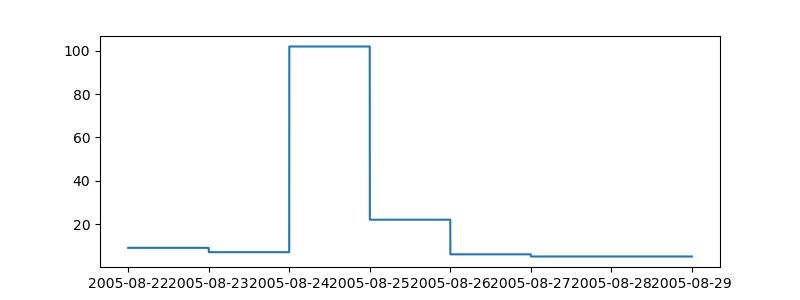

In [53]:
plt.figure(figsize=[8,3])
plt.plot(df1.index,AP[:,0])

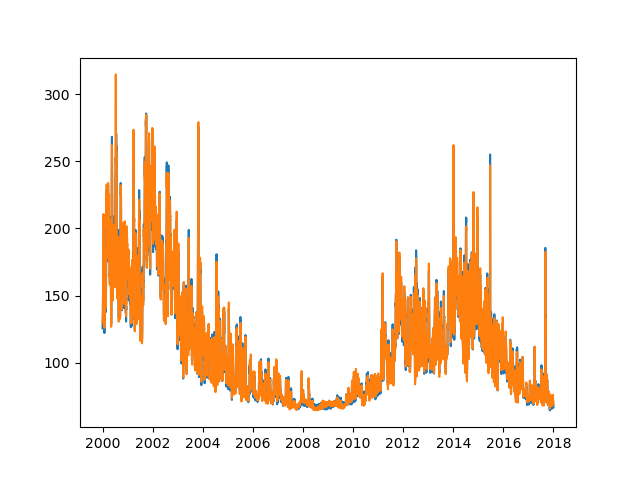

In [49]:
plt.figure()
plt.plot(flux['f107_adjusted (solar flux unit (SFU))'])
plt.plot(flux['f107_observed (solar flux unit (SFU))'])

In [12]:
## calculate earth radius at a given lat
def radius(B):
    B = np.deg2rad(B);
    a = 6.378137 * 10**6;
    b = 6.356752 * 10**6;
    c = (a**2*np.cos(B))**2
    d = (b**2*np.sin(B))**2
    e = (a*np.cos(B))**2
    f = (b*np.sin(B))**2
    R = np.sqrt((c+d)/(e+f))
    return R
R_e = [radius(inputs[i,2]) for i in range(len(df1))]

## nrlmsis code from Satellite toolbox (Julia)

In [25]:
%julia inputs=$inputs; AP=$AP;N= size(inputs)[1]; Data=[];
# %julia gd =[geocentric_to_geodetic(deg2rad(inputs[i,3]),R_e[i]+inputs[i,2]) for i=1:N];
%julia for i=1:N;push!(Data,nrlmsise00(inputs[i,1],inputs[i,2],deg2rad(inputs[i,3]),deg2rad(inputs[i,4]),inputs[i,6],inputs[i,5],AP[i,:],output_si=true,dversion=false)); end;
%julia Data_MSIS = DataFrame(Data);

# Data_MSIS = %julia Data_msis

In [26]:
rho = %julia Data_MSIS.den_Total
nO2 = %julia Data_MSIS.den_O2
nN2 = %julia Data_MSIS.den_N2
nO =  %julia Data_MSIS.den_O
# nAO = %julia Data_MSIS.den_aO
nAr = %julia Data_MSIS.den_Ar
nN =  %julia Data_MSIS.den_N
nHe = %julia Data_MSIS.den_He
nH =  %julia Data_MSIS.den_H
T_exo=%julia Data_MSIS.T_exo
Tz =  %julia Data_MSIS.T_alt


In [27]:
Data_MSIS_1 = pd.DataFrame({'rho': rho,
                       'nO2': nO2,
                        'nN2': nN2,
                        'nO' : nO,
                        'nN':nN,
                        'nHe':nHe,
                        'nH':nH,
                          'nAr':nAr,
                        'T_exo':T_exo,
                        'Tz':Tz
                       },index = df1.index[:N])

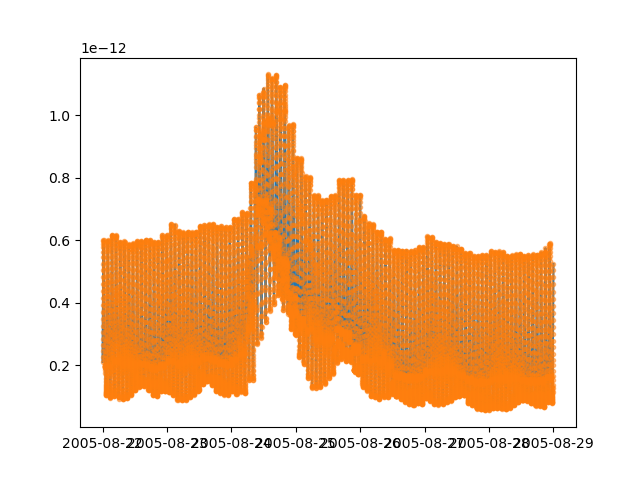

In [33]:
plt.figure()
plt.plot(Data_MSIS['rho'])
plt.plot(Data_MSIS['rho'],'--.',alpha=0.5)

In [ ]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
os.chdir(filepath)
Data_MSIS.to_csv('GRACEA_MSIS_jl_'+start.strftime("%Y-%m-%d")+'.csv')

## pynrlmsise00 (python)

In [ ]:
dens = np.zeros((N,9)); temp = np.zeros((N,2));
flags = [1 for i in range(24)]; flags[9]=-1;
for i in range(N):
    dens[i,:],temp[i,:] = nrlmsise00.msise_model(time=df1.index[i],
                                                 alt=df1['Altitude (km)'][i],
                                                lat=df1['Latitude (deg)'][i],
                                                lon=df1['Longitude (deg)'][i],
                                                f107a=inputs[i,5],
                                                f107=inputs[i,4],
                                                ap=AP[i,0],
                                                 lst=None,
                                                ap_a=list(AP[i,:]),
                                                flags=flags)

In [ ]:
Data_MSIS_py =  pd.concat([pd.DataFrame(dens),pd.DataFrame(temp)],axis = 1,ignore_index=True)
Data_MSIS_py.columns = ['nHe','nO','nN2','nO2','nAr','rho','nH','nN','nanO','Texo','Tz']
Data_MSIS_py.index = df1.index[:N]

In [6]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
os.chdir(filepath)
Data_MSIS_jl = pd.read_csv('GRACEA_MSIS_jl_'+start.strftime("%Y-%m-%d")+'.csv')

In [7]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
os.chdir(filepath)
Data_MSIS_py = pd.read_csv('GRACEA_MSIS_py_'+start.strftime("%Y-%m-%d")+'.csv')

In [8]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
os.chdir(filepath)
Data_MSIS_fort = pd.read_csv('GRACEA_MSIS_fort_'+start.strftime("%Y-%m-%d")+'.csv')
# Data_MSIS_fort.index=pd.DatetimeIndex(Data_MSIS_fort['Unnamed: 0'])

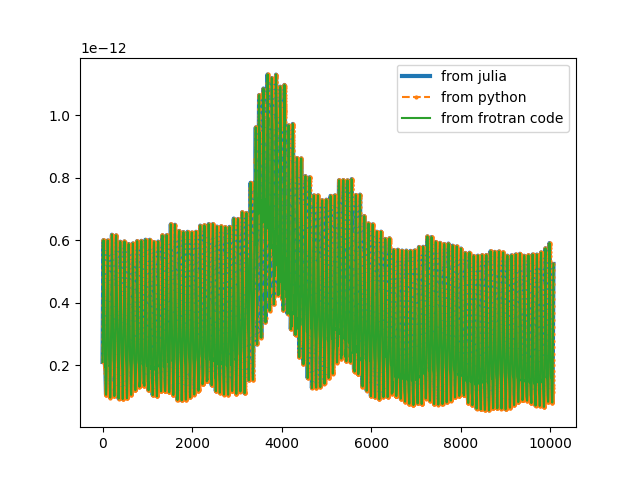

In [9]:
plt.figure()
plt.plot(Data_MSIS_jl['rho'],lw=3,label='from julia')
plt.plot(Data_MSIS_py['rho'],'--o',ms=2,label='from python')
plt.plot(Data_MSIS_fort['Rho']*10**3,label='from frotran code')
plt.legend()


### Altitude plot to compare with data output from ccmc website

In [25]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
os.chdir(filepath)
filename = 'msis20output_08222005.txt'
msis_ccmc = np.loadtxt(filename)

In [26]:
lat0 = 0;
lon0 = 0;
alt = np.arange(400,600,5);
t0 = dt.datetime(2005,8,22,0,1,0);

In [28]:
dens = np.zeros((len(alt),9)); temp = np.zeros((len(alt),2));
flags = [1 for i in range(24)]; flags[9]=-1;
for i,alt0 in enumerate(alt):
    dens[i,:],temp[i,:] = nrlmsise00.msise_model(time=t0,
                                                 alt=alt0,
                                                lat=lat0,
                                                lon=lon0,
                                                f107a=inputs[1,5],
                                                f107=inputs[1,4],
                                                ap=AP[1,0],
                                                 lst=df1['Local Solar Time (sec)'][1],
                                                ap_a=list(AP[1,:]),
                                                flags=flags)

In [37]:
# plt.figure()
# plt.plot(msis_ccmc[:,5],msis_ccmc[:,11]*10**3,'--s',ms=5)
# plt.plot(alt,dens[:,5])

In [30]:
lat0 = df1['Latitude (deg)'][1]
lon0 = df1['Longitude (deg)'][1]
alt = np.arange(400,600,4)

In [31]:
dens = np.zeros((len(alt),9)); temp = np.zeros((len(alt),2));
for i,alt0 in enumerate(alt):
    dens[i,:],temp[i,:] = nrlmsise00.msise_model(time=df1.index[1],
                                                 alt=alt0,
                                                lat=lat0,
                                                lon=lon0,
                                                f107a=inputs[1,5],
                                                f107=inputs[1,4],
                                                ap=AP[1,0],
                                                 lst=df1['Local Solar Time (sec)'][1],
                                                ap_a=list(AP[1,:]),
                                                flags=flags)

In [32]:
MSIS_comp =  pd.concat([pd.DataFrame(dens),pd.DataFrame(temp)],axis = 1,ignore_index=True)
MSIS_comp.columns = ['nHe','nO','nN2','nO2','nAr','rho','nH','nN','nanO','Texo','Tz']


In [ ]:
# N = 1000
# inputs = np.zeros((N,6)); AP = np.zeros((N,7));
# for i in tqdm(range(N)):
#     t = df1.index[i]
#     jd = t.to_julian_date()
#     t1 = julian.from_jd(np.ceil(jd))
#     inputs[i,0] = jd
#     inputs[i,1] = df1['Altitude (km)'][i]*1000
#     inputs[i,2] = df1['Latitude (deg)'][i]
#     inputs[i,3] = df1['Longitude (deg)'][i]
    
#     idx = np.where((SW_Data_daily['YEAR']==t.year) & (SW_Data_daily['DOY']==t.timetuple().tm_yday))[0][0]
#     # inputs[i,4] = SW_Data_daily['f10.7_index'][idx-1]
#     AP[i,0] = SW_Data_daily['ap_index, nT'][idx]
    
#     # idxa = np.where((SW_Data_daily.index >= t - dt.timedelta(days=45)) & (SW_Data_daily.index <= t + dt.timedelta(days=45)))[0] -1
#     # inputs[i,5] = SW_Data_daily['f10.7_index'][idxa].mean()
    
#     idx = np.where((flux.index==dt.datetime(t.year,t.month,t.day)))[0][0]
#     inputs[i,4] = flux['f107_observed (solar flux unit (SFU))'][idx-1]
    
#     idxa = np.where((flux.index >= t - dt.timedelta(days=45)) & (flux.index <= t + dt.timedelta(days=45)))[0]
#     inputs[i,5] = np.mean(flux['f107_observed (solar flux unit (SFU))'][idxa])
    
#     idx = np.where((SW_Data_hr['Year']==t.year)&(SW_Data_hr['DOY']==t.timetuple().tm_yday)&(SW_Data_hr['Hour']==t.hour))[0][0]
#     AP[i,1] = SW_Data_hr['Ap index'][idx] ## 3 hour Ap index at the time
    
#     t3 = t - dt.timedelta(hours=3)
#     idx3 = np.where((SW_Data_hr['Year']==t3.year)&(SW_Data_hr['DOY']==t3.timetuple().tm_yday)&(SW_Data_hr['Hour']==t3.hour))[0][0]
#     AP[i,2] = SW_Data_hr['Ap index'][idx3]  ## 3 hour Ap index 3 hrs before the time
    
#     t6 = t - dt.timedelta(hours=6)
#     idx6 = np.where((SW_Data_hr['Year']==t6.year)&(SW_Data_hr['DOY']==t6.timetuple().tm_yday)&(SW_Data_hr['Hour']==t6.hour))[0][0]
#     AP[i,3] = SW_Data_hr['Ap index'][idx6]  ## 3 hour Ap index 6 hrs before the time
    
#     t9 = t - dt.timedelta(hours=9)
#     idx9 = np.where((SW_Data_hr['Year']==t9.year)&(SW_Data_hr['DOY']==t9.timetuple().tm_yday)&(SW_Data_hr['Hour']==t9.hour))[0][0]
#     AP[i,4] = SW_Data_hr['Ap index'][idx9]
    
#     t12 = t - dt.timedelta(hours=12); t33 = t - dt.timedelta(hours=33);
#     idx12 = np.where((SW_Data_hr['Year']==t12.year)&(SW_Data_hr['DOY']==t12.timetuple().tm_yday)&(SW_Data_hr['Hour']==t12.hour))[0][0]
#     idx33 = np.where((SW_Data_hr['Year']==t33.year)&(SW_Data_hr['DOY']==t33.timetuple().tm_yday)&(SW_Data_hr['Hour']==t33.hour))[0][0]
#     # AP[i,5] = np.mean(SW_Data_hr['Ap index'][idx33:idx12])
#     AP[i,5]=SW_Data_hr['Ap index'][np.arange(idx33,idx12+1,3)].mean()
    
#     t36 = t - dt.timedelta(hours=36); t57 = t - dt.timedelta(hours=57);
#     idx36 = np.where((SW_Data_hr['Year']==t36.year)&(SW_Data_hr['DOY']==t36.timetuple().tm_yday)&(SW_Data_hr['Hour']==t36.hour))[0][0]
#     idx57 = np.where((SW_Data_hr['Year']==t57.year)&(SW_Data_hr['DOY']==t57.timetuple().tm_yday)&(SW_Data_hr['Hour']==t57.hour))[0][0]
#     # AP[i,6] = np.mean(SW_Data_hr['Ap index'][idx57:idx36])
#     AP[i,6]= SW_Data_hr['Ap index'][np.arange(idx57,idx36+1,3)].mean()
    
#     ## dont use index, instead use time. check if there's any gap in AP data/fill value
    

In [ ]:
# %julia GRACE_Data = py"GRACE_Data";
# %julia T = py"GRACE_Data.index";
# %julia global LAT = GRACE_Data["Latitude (deg)"];
# %julia global LON = GRACE_Data["Longitude (deg)"];
# %julia global ALT = GRACE_Data["Altitude (km)"];
# %julia global lst = GRACE_Data["Local Solar Time (sec)"]
# %julia N = 10000;
# %julia Data_MSIS = [];
# %julia F107 = $F107; F107a = $F107a; AP = $AP;
# %julia flag = NRLMSISE00_Flags(output_m_kg= true,F107_Mean= true,time_independent =  true,sym_annual = true,sym_semiannual = true,asym_annual = true,asym_semiannual = true,diurnal = true,semidiurnal = true,daily_ap = true,all_ut_long_effects = true,longitudinal = true,ut_mixed_ut_long = true,mixed_ap_ut_long = true,terdiurnal = true,departures_from_eq = true,all_tinf_var = true,all_tlb_var = true,all_tn1_var = true,all_s_var = true,all_tn2_var = true,all_nlb_var = true,all_tn3_var = true,turbo_scale_height = true,use_ap_array = true)
# %julia year = $year_in;
# %julia doy = $doy_in;
# %julia sec = $sec;
# %julia for i in 1:N; struc = conf_nrlmsise00(year[i],doy[i],sec[i],ALT[i],LAT[i],LON[i],lst[i],F107a[i],F107[i],AP[i,:],flag); push!(Data_MSIS,gtd7d(struc)) ;end;
# %julia Data_MSIS = DataFrame(Data_MSIS);
# %julia Data_MSIS = select!(Data_MSIS,Not(:flags));



In [ ]:
# # filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
# os.chdir(filepath)
# filename = 'omni_01_av.dat';
# df = np.loadtxt(filename)
# time_array = [dt.datetime(int(df[i,0]),1,1)+dt.timedelta(days=int(df[i,1])-1)+dt.timedelta(hours=int(df[i,2])) for i in range(len(df))]
# columns = ['Year','Decimal Day','Hour','Bartels rotation number','ID for IMF spacecraft',\
#           'ID for SW plasma spacecraft','No of points in the IMF averages','No of points in the plasma averages',\
#           'Field Magnitude Average |B|','Magnitude of Average Field Vector','Lat.Angle of Aver. Field Vector',\
#           'Long.Angle of Aver.Field Vector','Bx GSE, GSM','By GSE','Bz GSE','By GSM','Bz GSM','sigma|B|',\
#            'sigma B','sigma Bx','sigma By','sigma Bz','Proton temperature','Proton Density','Plasma (Flow) speed',\
#            'Plasma Flow Long. Angle','Plasma  Flow Lat. Angle','Na/Np','Flow Pressure','sigma T','sigma N','sigma V',\
#            'sigma phi V','sigma theta V','sigma-Na/Np','Electric field','Plasma beta','Alfven mach number',\
#            'Kp','R','DST Index','AE-index','Proton flux>1 Mev','Proton flux>2 Mev','Proton flux>4 Mev','Proton flux>10 Mev',\
#            'Proton flux>30 Mev','Proton flux>60 Mev','Flag','ap-index','f10.7_index','PC(N) index','AL-index, from Kyoto',\
#            'AU-index, from Kyoto','Magnetosonic mach number']
# SW_Data_daily = pd.DataFrame(df,index=pd.DatetimeIndex(time_array),columns=columns)
# idx = np.where((pd.DatetimeIndex(time_array) >= dt.datetime(start.year,1,1)) & (pd.DatetimeIndex(time_array) <= dt.datetime(start.year+1,1,1)))[0]
# SW_Data_daily = SW_Data_daily.iloc[idx,:]
# del df

In [ ]:
# # filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
# os.chdir(filepath)
# filename = 'omni2_2005.dat'
# df = np.loadtxt(filename)
# time_array = [dt.datetime(int(df[i,0]),1,1)+dt.timedelta(days=int(df[i,1])-1)+dt.timedelta(hours=int(df[i,2])) for i in range(len(df))]
# columns = ['Year','Decimal Day','Hour','Bartels rotation number','ID for IMF spacecraft',\
#           'ID for SW plasma spacecraft','No of points in the IMF averages','No of points in the plasma averages',\
#           'Field Magnitude Average |B|','Magnitude of Average Field Vector','Lat.Angle of Aver. Field Vector',\
#           'Long.Angle of Aver.Field Vector','Bx GSE, GSM','By GSE','Bz GSE','By GSM','Bz GSM','sigma|B|',\
#            'sigma B','sigma Bx','sigma By','sigma Bz','Proton temperature','Proton Density','Plasma (Flow) speed',\
#            'Plasma Flow Long. Angle','Plasma  Flow Lat. Angle','Na/Np','Flow Pressure','sigma T','sigma N','sigma V',\
#            'sigma phi V','sigma theta V','sigma-Na/Np','Electric field','Plasma beta','Alfven mach number',\
#            'Kp','R','DST Index','AE-index','Proton flux>1 Mev','Proton flux>2 Mev','Proton flux>4 Mev','Proton flux>10 Mev',\
#            'Proton flux>30 Mev','Proton flux>60 Mev','Flag','ap-index','f10.7_index','PC(N) index','AL-index, from Kyoto',\
#            'AU-index, from Kyoto','Magnetosonic mach number']
# SW_Data_hr = pd.DataFrame(df[:,49:51],index=pd.DatetimeIndex(time_array),columns=columns[49:51])
# del df

In [15]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\';
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
# os.chdir(filepath)
# filename = 'omni2_daily.txt'
# SW_Data_daily = pd.DataFrame(np.loadtxt(filename),
#                        columns = ['YEAR','DOY','Hour','Scalar B, nT','BX, nT (GSE, GSM)','BY, nT (GSE)','BZ, nT (GSE)','Kp index','R (Sunspot No.)','Dst-index, nT','ap_index, nT','f10.7_index','AE-index, nT','AL-index, nT','AU-index, nT','pc-index'])
# time_array = [dt.datetime(int(SW_Data_daily.iloc[i,0]),1,1,0,0,0) + dt.timedelta(days = int(SW_Data_daily.iloc[i,1]-1)) + dt.timedelta(hours = int(SW_Data_daily.iloc[i,2])) for i in range(len(SW_Data_daily))]
# SW_Data_daily.index = pd.DatetimeIndex(time_array)
# SW_Data_daily= SW_Data_daily[(SW_Data_daily.index >= dt.datetime(year,1,1,0,0,0)) & (SW_Data_daily.index < dt.datetime(year+1,1,1,0,0,0))]

In [21]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\';
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/';
# os.chdir(filepath)
# filename = 'noaa_indices.txt'
# noaa_ind = np.loadtxt(filename)
# time_array = pd.DatetimeIndex([dt.datetime(int(noaa_ind[i,0]),int(noaa_ind[i,1]),int(noaa_ind[i,2])) for i in range(len(noaa_ind))])
# idx = np.where((time_array >= dt.datetime(start.year,1,1)) & (time_array < dt.datetime(start.year+1,1,1)))[0]
# columns=['YYYY','MM','DD','days','days_m','BSR','dB','KP0','KP1','KP2','KP3','KP4','KP5','KP6','KP7',\
#          'AP0','AP1','AP2','AP3','AP4','AP5','AP6','AP7','AP','SN','F10.7OBS','F10.7ADJ','D'];
# noaa_ind = pd.DataFrame(noaa_ind[idx,:],index = time_array[idx],columns=columns)

In [1]:
# noaa_AP=pd.DataFrame()
# for i in range(len(noaa_ind)):
#     x = [noaa_ind['AP0'][i],noaa_ind['AP1'][i],noaa_ind['AP2'][i],noaa_ind['AP3'][i],noaa_ind['AP4'][i],noaa_ind['AP5'][i],noaa_ind['AP6'][i],noaa_ind['AP7'][i]]
#     y = np.zeros(24);
#     for j,x0 in enumerate(x):
#         y[3*j:3*(j+1)] = x0*np.ones(3)
#     dtime = [noaa_ind.index[i] + dt.timedelta(hours=k) for k in range(24)];
#     df = pd.DataFrame(list(zip(dtime,y)))
    